
#  Unemployment Analysis with Python

In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

plt.style.use('seaborn-v0_8')
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')


## 1. Load & Clean Data

In [13]:

DATA_PATH = "Unemployment in India (1).csv"

df = pd.read_csv(DATA_PATH)

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace('[^a-z0-9]+','_',regex=True)

# Parse date
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Rename unemployment rate column
df = df.rename(columns={'estimated_unemployment_rate':'unemployment_rate'})

df.head()


,region,date,frequency,estimated_unemployment_rate_,estimated_employed,estimated_labour_participation_rate_,area
0,Andhra Pradesh,2019-05-31,Monthly,3.65,"11,999,139.00",43.24,Rural
1,Andhra Pradesh,2019-06-30,Monthly,3.05,"11,755,881.00",42.05,Rural
2,Andhra Pradesh,2019-07-31,Monthly,3.75,"12,086,707.00",43.50,Rural
3,Andhra Pradesh,2019-08-31,Monthly,3.32,"12,285,693.00",43.97,Rural
4,Andhra Pradesh,2019-09-30,Monthly,5.17,"12,256,762.00",44.68,Rural


## 2. Dataset Overview

In [14]:
# Rename unemployment rate column
df = df.rename(columns={'estimated_unemployment_rate':'unemployment_rate'})

In [17]:
for col in df.columns:
    if "unemployment" in col and "rate" in col:
        df = df.rename(columns={col: "unemployment_rate"})
        break

In [18]:

df.info()
df.describe(include='all').T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   region                                740 non-null    object        
 1   date                                  740 non-null    datetime64[ns]
 2   frequency                             740 non-null    object        
 3   unemployment_rate                     740 non-null    float64       
 4   estimated_employed                    740 non-null    float64       
 5   estimated_labour_participation_rate_  740 non-null    float64       
 6   area                                  740 non-null    object        
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 42.1+ KB


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
region,740,28,Andhra Pradesh,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,740,NaN,NaN,NaN,2019-12-12 18:36:58.378378496,2019-05-31 00:00:00,2019-08-31 00:00:00,2019-11-30 00:00:00,2020-03-31 00:00:00,2020-06-30 00:00:00,NaN
frequency,740,2,Monthly,381,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unemployment_rate,740.00,NaN,NaN,NaN,11.79,0.00,4.66,8.35,15.89,76.74,10.72
estimated_employed,740.00,NaN,NaN,NaN,"7,204,460.03","49,420.00","1,190,404.50","4,744,178.50","11,275,489.50","45,777,509.00","8,087,988.43"
estimated_labour_participation_rate_,740.00,NaN,NaN,NaN,42.63,13.33,38.06,41.16,45.51,72.57,8.11
area,740,2,Urban,381,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. National Unemployment Trend

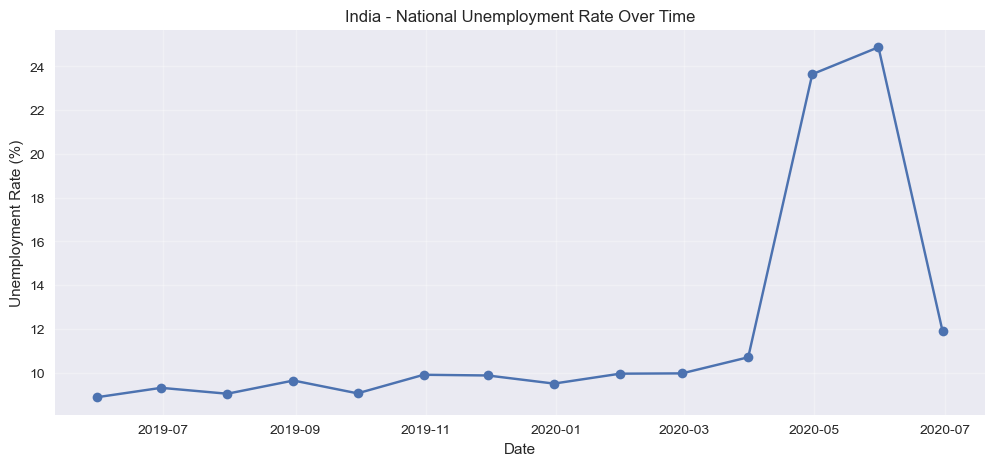

In [19]:

national = df.groupby('date')['unemployment_rate'].mean()

plt.figure(figsize=(12,5))
plt.plot(national.index, national.values, marker='o')
plt.title("India - National Unemployment Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Unemployment Rate (%)")
plt.grid(True, alpha=0.3)
plt.show()


## 4. Covid-19 Impact Analysis

Pre-Covid mean: 9.51%
Post-Covid mean: 17.78%
Change: 8.27 pp
P-value: 0.1149


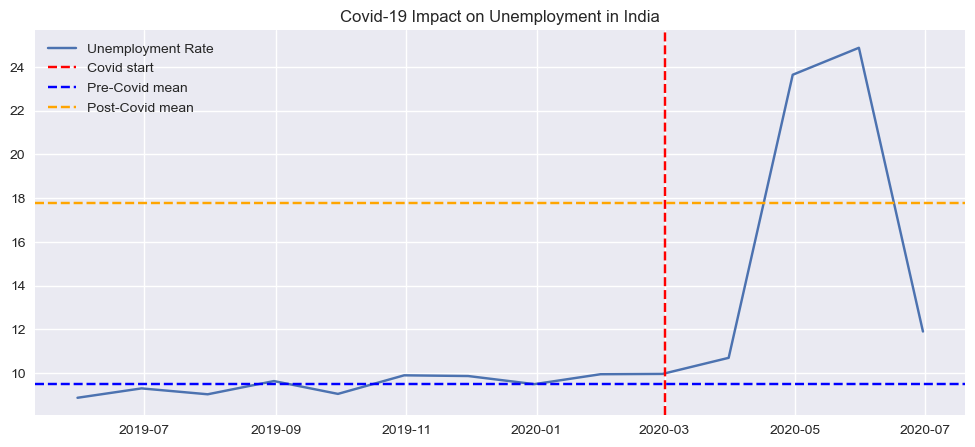

In [20]:

covid_start = pd.Timestamp("2020-03-01")

pre = national[national.index < covid_start]
post = national[national.index >= covid_start]

pre_mean, post_mean = pre.mean(), post.mean()
lift = post_mean - pre_mean

t_stat, p_val = stats.ttest_ind(post, pre, equal_var=False, nan_policy="omit")

print(f"Pre-Covid mean: {pre_mean:.2f}%")
print(f"Post-Covid mean: {post_mean:.2f}%")
print(f"Change: {lift:.2f} pp")
print(f"P-value: {p_val:.4f}")

plt.figure(figsize=(12,5))
plt.plot(national.index, national.values, label="Unemployment Rate")
plt.axvline(covid_start, color="red", linestyle="--", label="Covid start")
plt.axhline(pre_mean, linestyle="--", color="blue", label="Pre-Covid mean")
plt.axhline(post_mean, linestyle="--", color="orange", label="Post-Covid mean")
plt.legend()
plt.title("Covid-19 Impact on Unemployment in India")
plt.show()


## 5. Seasonal Decomposition

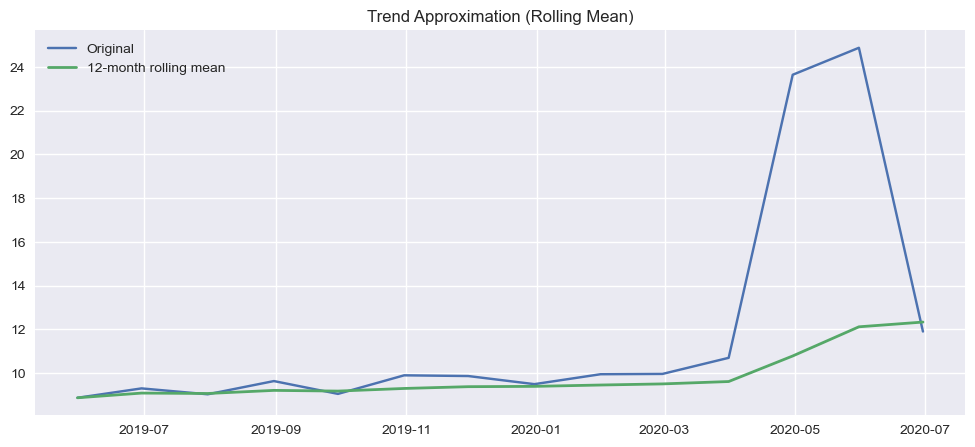

In [31]:
roll = series.rolling(12, min_periods=1).mean()

plt.figure(figsize=(12,5))
plt.plot(series.index, series, label="Original")
plt.plot(roll.index, roll, label="12-month rolling mean", linewidth=2)
plt.legend()
plt.title("Trend Approximation (Rolling Mean)")
plt.show()

## 6. Regional Analysis

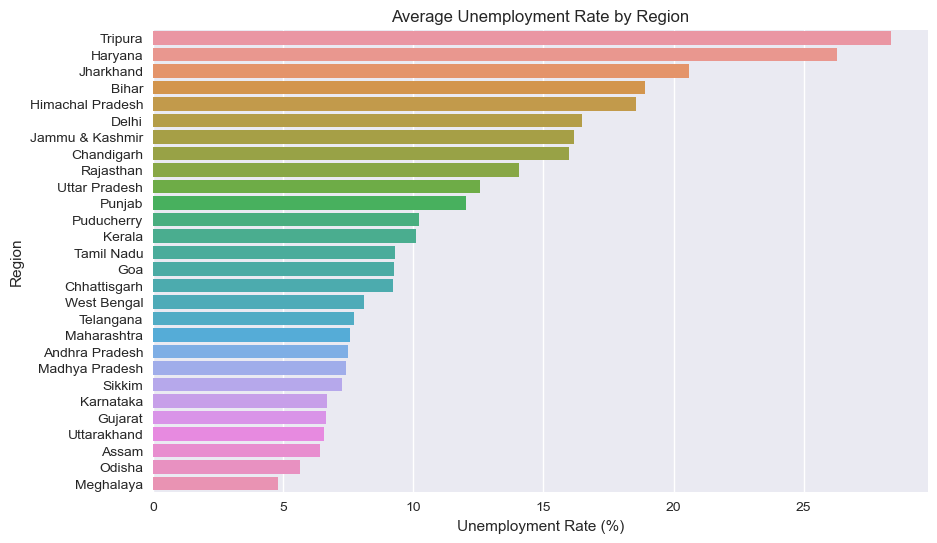

In [22]:

region_mean = df.groupby('region')['unemployment_rate'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=region_mean.values, y=region_mean.index)
plt.title("Average Unemployment Rate by Region")
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("Region")
plt.show()


## 7. Rural vs Urban Comparison

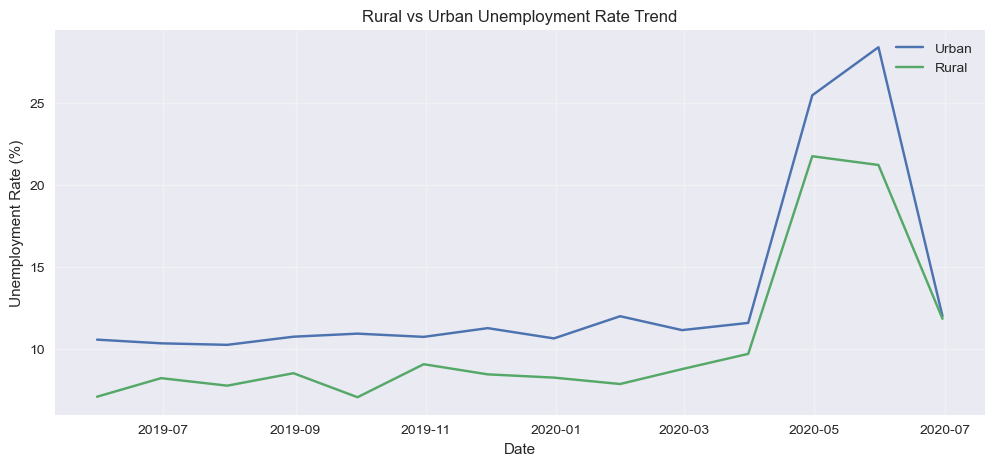

In [23]:

area_trend = df.groupby(['date','area'])['unemployment_rate'].mean().unstack()

plt.figure(figsize=(12,5))
plt.plot(area_trend.index, area_trend['Urban'], label="Urban")
plt.plot(area_trend.index, area_trend['Rural'], label="Rural")
plt.legend()
plt.title("Rural vs Urban Unemployment Rate Trend")
plt.xlabel("Date")
plt.ylabel("Unemployment Rate (%)")
plt.grid(True, alpha=0.3)
plt.show()
